In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import nltk
import string
import re
import matplotlib.pyplot as plt

### Data preprocessing for the Neural Network

In [2]:
pet = pd.read_json('/Users/harishprabhala/Downloads/Pet_Supplies_5.json', lines=True)

In [3]:
pet = pet[['overall','summary']]

In [4]:
pet["overall"] = pet["overall"].apply(lambda x: '1' if x > 3 else '0') 

In [5]:
pos = pet.loc[pet['overall']=='1']

In [6]:
neg = pet.loc[pet['overall']=='0']

In [7]:
pos_text = pos['summary']
neg_text = neg['summary']

In [8]:
all_text = pet['summary']

In [9]:
import itertools
from collections import Counter

In [10]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [40]:
def preprocess (eachline):
    sentence = eachline.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    clean_words =(w for w in tokens if not w.isnumeric()) 
    return ' '.join(clean_words)

In [41]:
def load_data_and_labels():
   
    # Load data 
    positive_examples = [s.strip() for s in pos_text]
    negative_examples = [s.strip() for s in neg_text]
    # Split by words
    x_text = positive_examples + negative_examples
    x_text = [preprocess(l) for l in x_text]
    x_text = [s.split(" ") for s in x_text]
    # Generate labels
    positive_labels = [[1,0] for _ in positive_examples]
    negative_labels = [[0,1] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    return [x_text, y]

In [42]:
def pad_sentences(sentences, padding_word="</s>"):
    """
    Pads all sentences to the same length. The length is defined by the longest sentence.
    Returns padded sentences.
    """
    sequence_length = max(len(x) for x in sentences)
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
    return padded_sentences

In [43]:
def build_vocab(sentences):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return [vocabulary, vocabulary_inv]

In [44]:
def build_input_data(sentences, labels, vocabulary):
    """
    Maps sentences and labels to vectors based on a vocabulary.
    """
    x = np.array([[vocabulary[word] for word in sentence] for sentence in sentences])
    y = np.array(labels)
    return [x, y]

In [45]:
sentences, labels = load_data_and_labels()
sentences_padded = pad_sentences(sentences)
vocabulary, vocabulary_inv = build_vocab(sentences_padded)
x, y = build_input_data(sentences_padded, labels, vocabulary)

vocab_size = len(vocabulary)

In [46]:
vocab_size

17850

In [18]:
from sklearn.cross_validation import train_test_split

/Users/harishprabhala/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [47]:
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

# split train/dev set
# there are a total of 10662 labeled examples to train on
#x_train, x_test = x_shuffled[:-1000], x_shuffled[-1000:]
#y_train, y_test = y_shuffled[:-1000], y_shuffled[-1000:]

x_train, x_test, y_train, y_test = train_test_split(x_shuffled, y_shuffled, test_size=0.33)

sentence_size = x_train.shape[1]

print ('Train/Test split: %d/%d' % (len(y_train), len(y_test)))
print ('Train shape:', x_train.shape)
print ('Test shape:', x_test.shape)
print ('vocab_size', vocab_size)
print ('sentence max words', sentence_size)

Train/Test split: 105750/52086
Train shape: (105750, 30)
Test shape: (52086, 30)
vocab_size 17850
sentence max words 30


## Multilayer Perceptron (MLP) with four hidden layers

#### Using TensorFlow

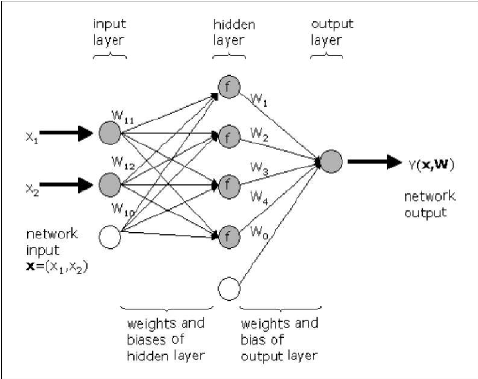

In [3]:
from IPython.display import Image
Image(filename='//Users/harishprabhala/Downloads/Neural net.png')

In [20]:
import tensorflow as tf

In [60]:
n_nodes_hl1 = 1000
n_nodes_hl2 = 1000
n_nodes_hl3 = 1000
n_nodes_hl4 = 1000

n_classes = 2
batch_size = 100
number_epochs = 10

In [50]:
x = tf.placeholder('float')
y = tf.placeholder('float')

In [51]:
hidden_1_layer = {'weight':tf.Variable(tf.random_normal([len(x_train[0]), n_nodes_hl1])),
                  'bias':tf.Variable(tf.random_normal([n_nodes_hl1]))}

hidden_2_layer = {'weight':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                  'bias':tf.Variable(tf.random_normal([n_nodes_hl2]))}

hidden_3_layer = {'weight':tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                  'bias':tf.Variable(tf.random_normal([n_nodes_hl3]))}

hidden_4_layer = {'weight':tf.Variable(tf.random_normal([n_nodes_hl3, n_nodes_hl4])),
                  'bias':tf.Variable(tf.random_normal([n_nodes_hl4]))}

output_layer = {'weight':tf.Variable(tf.random_normal([n_nodes_hl4, n_classes])),
                'bias':tf.Variable(tf.random_normal([n_classes])),}

In [55]:
def neural_network_model(data):

    l1 = tf.add(tf.matmul(data,hidden_1_layer['weight']), hidden_1_layer['bias'])
    l1 = tf.nn.relu(l1)

    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weight']), hidden_2_layer['bias'])
    l2 = tf.nn.relu(l2)

    l3 = tf.add(tf.matmul(l2,hidden_3_layer['weight']), hidden_3_layer['bias'])
    l3 = tf.nn.relu(l3)
    
    l4 = tf.add(tf.matmul(l3,hidden_4_layer['weight']), hidden_4_layer['bias'])
    l4 = tf.nn.relu(l4)

    output = tf.matmul(l4,output_layer['weight']) + output_layer['bias']

    return output

In [59]:
def train_neural_network(x):
    prediction = neural_network_model(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
    
        for epoch in range(number_epochs):
            epoch_loss = 0
            i=0
            while i < x_train.shape[0]:
                start = i
                end = i+batch_size
                batch_x = np.array(x_train[start:end])
                batch_y = np.array(y_train[start:end])


                _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                              y: batch_y})
                epoch_loss += c
                i+=batch_size
    
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

        print('Accuracy:',accuracy.eval({x:x_test, y:y_test}))



In [57]:
train_neural_network(x)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 1 completed out of 10 loss: 43986638935.5
Epoch 2 completed out of 10 loss: 22530532362.2
Epoch 3 completed out of 10 loss: 14898702297.9
Epoch 4 completed out of 10 loss: 11097606738.5
Epoch 5 completed out of 10 loss: 7782826075.75
Epoch 6 completed out of 10 loss: 5833431690.56
Epoch 7 completed out of 10 loss: 4564821568.38
Epoch 8 completed out of 10 loss: 3408047976.12
Epoch 9 completed out of 10 loss: 2487923995.53
Epoch 10 completed out of 10 loss: 2005104086.91
Accuracy: 0.760377


## LTSM Recurrent Neural Network (RNN)

#### Using Keras

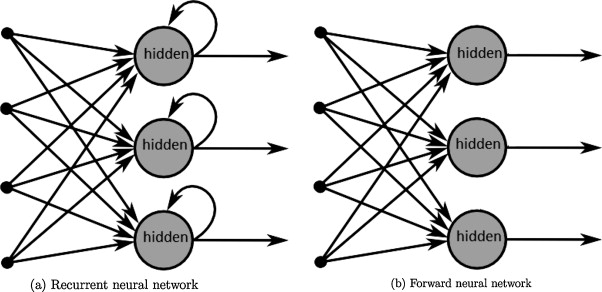

In [5]:
Image(filename='/Users/harishprabhala/Downloads/RNN.jpeg')

In [61]:
import keras

Using TensorFlow backend.


In [63]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

In [65]:
np.random.seed(42)

In [66]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=sentence_size))
model.add(LSTM(100))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 32)            571200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 624,602
Trainable params: 624,602
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3, batch_size=64)

Train on 105750 samples, validate on 52086 samples
Epoch 1/3
105750/105750 [==============================] - 253s - loss: 0.3381 - acc: 0.8632 - val_loss: 0.2916 - val_acc: 0.8825
Epoch 2/3
105750/105750 [==============================] - 248s - loss: 0.2738 - acc: 0.8912 - val_loss: 0.2906 - val_acc: 0.8825
Epoch 3/3
105750/105750 [==============================] - 251s - loss: 0.2486 - acc: 0.9010 - val_loss: 0.3038 - val_acc: 0.8743


In [69]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.43%
